In [1]:
import pandas as pd
import numpy as np
import os
import googlemaps
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt
GOOGLE_API_KEY=os.environ['GOOGLE_API_KEY']


## Import Data
- Read in housing data
- Geocode addresses using google maps api (https://github.com/googlemaps/google-maps-services-python)
- Split into train/test sets that all algorithms will use

In [2]:
PATH = '/Users/michaelfutch/gtu/ml/project1/'
FILE = PATH + 'data/data.csv'
rebuild = False # set to True if rebuilding dataset (cost $ to geocode)

In [3]:
# data at: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

if rebuild:
    # read data
    dat = pd.read_csv(FILE)
    
    # cleaning steps
    dat['address'] = dat[['street','city','statezip']].agg(' '.join, axis=1) 
    dat['date'] = pd.to_datetime(dat['date'])
    dat['day'] = ((dat['date'] - dat['date'].min()) / np.timedelta64(1,'D')).astype(int)

    # get lat/lon from google maps api
    gmaps = googlemaps.Client(key=GOOGLE_API_KEY)
    addresses = list(dat['address'])
    lat_lon = np.empty((len(addresses),2))
    neighborhood = []
    ct = 0
    for address in addresses:
        geocode_result = gmaps.geocode(address)
        lat_lon[ct] = np.array([[geocode_result[0]['geometry']['location']['lat'],geocode_result[0]['geometry']['location']['lng']]])
        ct += 1
        
        
    X_full = dat[['day', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
           'floors', 'waterfront', 'view', 'condition', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated']].to_numpy()
    X_full = np.append(X_full, lat_lon, axis=1)
    y_full = np.array(dat.price)

    

    # split data
    X, X_val, y, y_val = train_test_split(X_full, y_full, test_size = 0.33, random_state = 2072020)
    
    # save data to avoid re-geocoding
    with open('./data/pickled', 'wb') as f:
        pickle.dump((X, X_val, y, y_val, dat, lat_lon), file=f)

else:
    # load saved data if not rebuilding
    with open('./data/pickled', 'rb') as f:
        X, X_val, y, y_val, dat, lat_lon = pickle.load(f)
        
        
        ## Trim extreme tails
        pct2, pct98 = np.percentile(y,[2,98])
        X = X[(y >= pct2) & (y <= pct98)]
        y = y[(y >= pct2) & (y <= pct98)]
        X_val = X_val[(y_val >= pct2) & (y_val <= pct98)]
        y_val = y_val[(y_val >= pct2) & (y_val <= pct98)]

### Description of datasets after split
- X_full,y_full = full dataset of covariates and prices
- X_val, y_val = holdout for comparison across all algorithms
- X,y = dataset for training for each algo, may be split again


In [57]:

n_splits = 5
n = X_train.shape[0] // n_splits
ind = [i*n for i in range(5)]
ind.reverse()
for i in range(n_splits):
    ix = [j >= ind[i] for j in range(X_train.shape[0])]
    X_train_i = X_train[ix]
    y_train_i = y_train[ix]
    clf = tree.DecisionTreeRegressor(random_state=0)
    clf.fit(X_train_i, y_train)
    pred_y_test = clf.predict(y_train)
    
    metric = r2_score(y_test, pred_y_test)
    
    


(397, 15)
(793, 15)
(1189, 15)
(1585, 15)
(1981, 15)


(1981, 15)

In [ ]:
def learning_curve_data(clf, splits=10):
    dims = X_train.shape[0] // 10
    

## Decision Trees
- Sklearn uses CART

In [44]:
from sklearn import tree
dt_results = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

In [61]:
def plot_learning(val = 'roc_auc', x = 'max depth'):
    D = eval(val)
    depths = sorted(D.keys())
    train_scores = [value[0] for key, value in D.items()]
    test_scores = [value[1] for key, value in D.items()]
    
    
    fig, ax = plt.subplots()
    ax.set_xlabel(x)
    ax.set_ylabel(val)
    ax.set_title(val + " vs " + x + " for training and testing sets")
    ax.plot(depths, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(depths, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax.legend()
    return plt

### Run CART without cross-validation or any protection for overfitting

In [59]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Node count:", clf.tree_.node_count)
print("Depth:", clf.get_depth())

print("Training RMSE, Validation RMSE:")
r2_score(y_train, pred_y), r2_score(y_test, pred_y_test)


Node count: 3855
Depth: 23
Training RMSE, Validation RMSE:


(1.0, 0.5856446974837193)

#### CART without restrictions massively overfit the data. The root MSE is zero indicating perfect fit on the training data, but much higher on the validation data not seen by the algorithm - a clear indication of overfitting. The visualization shows a very complicated tree structure.

#### Builds a very deep tree that perfectly predicts the training data but does poorly on data it hasn't seen

In [569]:
import graphviz
clf_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(clf_data) 
graph.render("CART_unrestricted") 

'CART_unrestricted.pdf'

#### Add restriction that each terminal node must have at least 2 cases

In [570]:
clf = tree.DecisionTreeRegressor(random_state=0, min_samples_leaf=2)
clf = clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Node count:", clf.tree_.node_count)
print("Training RMSE, Validation RMSE, R2 train, R2 test:")
mean_squared_error(y_train, pred_y, squared = False), mean_squared_error(y_test, pred_y_test, squared = False), clf.score(X_train, y_train), clf.score(X_test, y_test)

Node count: 1697
Training RMSE, Validation RMSE, R2 train, R2 test:


(39633.585480146045, 163742.5677737972, 0.975920410729231, 0.6033867489648765)

In [118]:
clf_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(clf_data) 
graph.render("CART_min_leaf2") 

'CART_min_leaf2.pdf'

#### More balanced train/validation error, but still overfitting the data


#### Post-pruning with min cost complexity
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

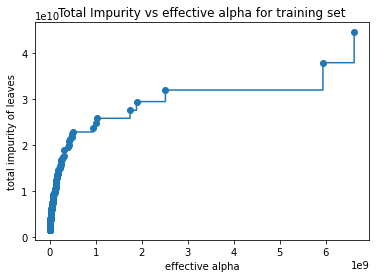

In [571]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [572]:

clfs = []

for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha, min_samples_leaf=2)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print("Training RMSE, Validation RMSE, R2 train, R2 test:")
mean_squared_error(y_train, pred_y, squared = False), mean_squared_error(y_test, pred_y_test, squared = False), clf.score(X_train, y_train), clf.score(X_test, y_test)

Training RMSE, Validation RMSE, R2 train, R2 test:


(39633.585480146045,
 163742.5677737972,
 1.1102230246251565e-16,
 -0.001709901094136601)

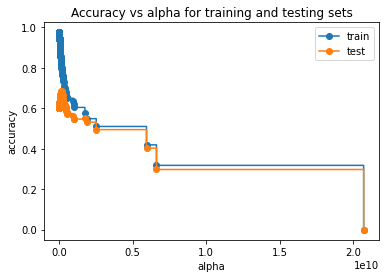

In [573]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [79]:
mins = list(range(1,23))
r2 = {}
for m in mins:
    clf = tree.DecisionTreeRegressor(max_depth=m)
    clf = clf.fit(X_train, y_train)
    pred_y_train = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)
    r2[m] = r2_score(y_train, pred_y_train), r2_score(y_test, pred_y_test) 
r2

{1: (0.3175724313182079, 0.2971739428972825),
 2: (0.5100104108863177, 0.49438226424947296),
 3: (0.5927347927720196, 0.5671668372436309),
 4: (0.656277344259529, 0.5898437592494803),
 5: (0.7188576997894259, 0.6195075509675492),
 6: (0.7653162315487809, 0.6693921769113867),
 7: (0.8076158428105044, 0.6612153193572832),
 8: (0.8547082076973374, 0.6673171867117985),
 9: (0.899375135965792, 0.6485097844509627),
 10: (0.9335551177535404, 0.6387080578535429),
 11: (0.957514907969795, 0.6162490333017194),
 12: (0.9748103523026237, 0.6151646612538855),
 13: (0.9871304992976615, 0.5920957508319409),
 14: (0.9936485508845315, 0.5939532553586435),
 15: (0.9969686419108357, 0.5863701462416051),
 16: (0.9988739301073607, 0.5702817473180479),
 17: (0.9995940744402291, 0.5909119238138515),
 18: (0.9998599618261689, 0.5928281041571404),
 19: (0.9999711600883558, 0.5758915362198772),
 20: (0.9999956788769762, 0.5859650382888176),
 21: (0.9999990933355627, 0.6118632840360215),
 22: (0.9999999961309185

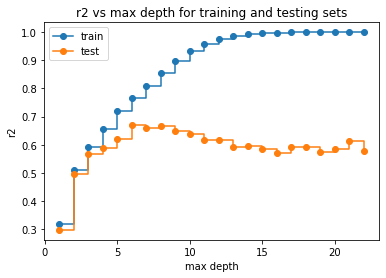

In [80]:
plt = plot_learning('r2',x='max depth')
plt.savefig('./paper/figures/house_dt_learn_r2_depth.png', format='png', transparent=True)
plt.show()


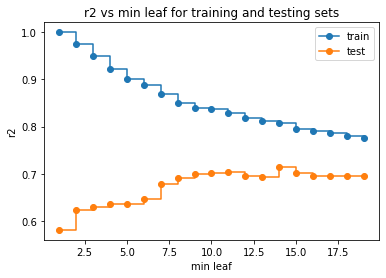

In [96]:
mins = list(range(1,20))
r2 = {}
for m in mins:
    clf = tree.DecisionTreeRegressor(min_samples_leaf=m)
    clf = clf.fit(X_train, y_train)
    pred_y_train = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)
    r2[m] = r2_score(y_train, pred_y_train), r2_score(y_test, pred_y_test) 
plt = plot_learning('r2',x='min leaf')
plt.savefig('./paper/figures/house_dt_learn_r2_leaf.png', format='png', transparent=True)
plt.show()

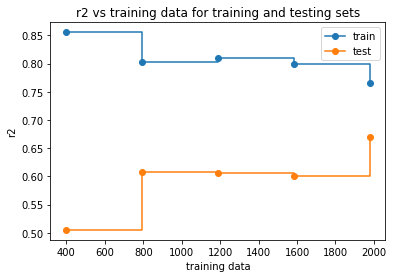

In [129]:
n_splits = 5
n = X_train.shape[0] // n_splits
ind = [i*n for i in range(5)]
ind.reverse()
r2 = {}
for i in range(n_splits):
    ix = [j >= ind[i] for j in range(X_train.shape[0])]
    X_train_i = X_train[ix]
    y_train_i = y_train[ix]
    clf = tree.DecisionTreeRegressor(random_state=0, max_depth=6)
    clf.fit(X_train_i, y_train_i)
    pred_y_test = clf.predict(X_test)
    pred_y_i = clf.predict(X_train_i)
    r2[ind[i]+n] = r2_score(y_train_i, pred_y_i), r2_score(y_test, pred_y_test) 
plt = plot_learning('r2',x='training data')
plt.savefig('./paper/figures/house_dt_learn_r2_data.png', format='png', transparent=True)
plt.show()

### Set the max_depth=3, errors much more balanced. Validation error smaller than unrestricted.

In [106]:

mse = {}
clfs = {}
best = None
best_score = -1000
for depth in range(2,8):
    for split in range(5,30):
        clf = tree.DecisionTreeRegressor(random_state=0, min_samples_leaf=split, max_depth=depth)
        clf.fit(X_train, y_train)
        if r2_score(y_test, clf.predict(X_test)) > best_score:
            best_score = r2_score(y_test, clf.predict(X_test))
            best = clf, depth, split

best, best_score

((DecisionTreeRegressor(max_depth=7, min_samples_leaf=14, random_state=0),
  7,
  14),
 0.6969584329004015)

In [108]:
clf = tree.DecisionTreeRegressor(random_state=0, max_depth=7, min_samples_leaf=14)
clf = clf.fit(X, y)
pred_y = clf.predict(X)

clf.score(X, y), clf.score(X_val, y_val)

(0.7689031814276044, 0.6863910248484426)

In [104]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.7489708391017302, 0.6747181885933773)

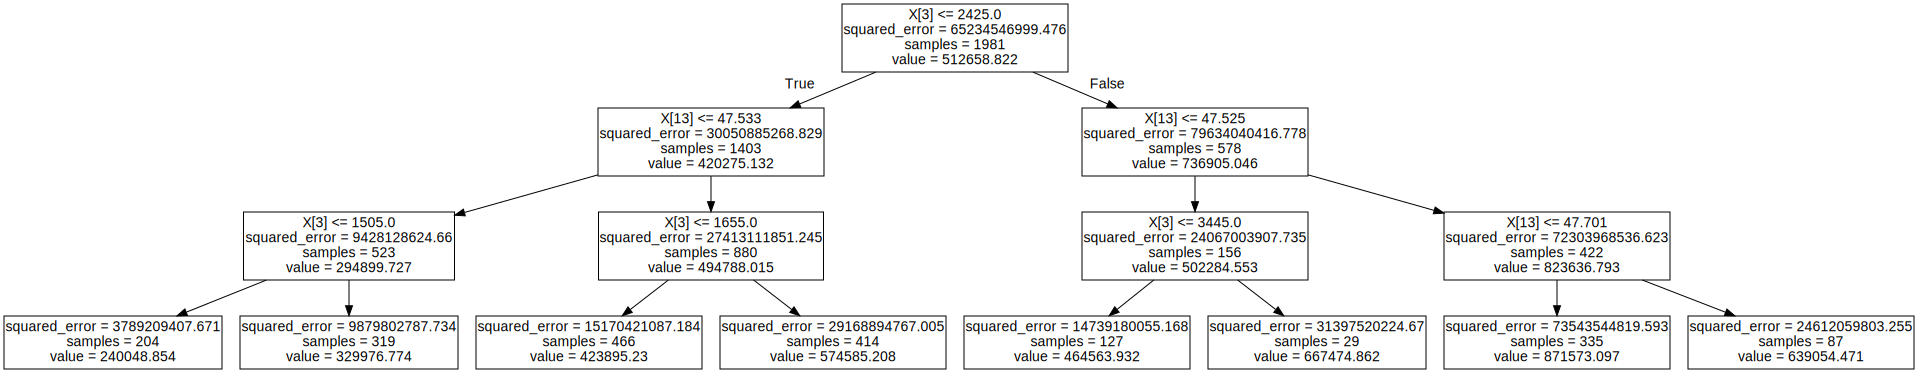

In [576]:
clf_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(clf_data) 
graph.render("CART_max_depth3") 
graph

## K-Nearest Neighbors

In [122]:
from sklearn.neighbors import KNeighborsRegressor


In [123]:
def return_best_model(X_train, X_test, y_train, y_test):

    best_model = None
    best_score = -1000
    K = [k for k in range(1,10)]
    weights = ['uniform', 'distance']

    for k in K:
        for weight in weights:
            knn = KNeighborsRegressor(n_neighbors=k, weights=weight)
            knn.fit(X_train, y_train)
            if knn.score(X_test, y_test) > best_score:
                best_model = knn
                best_score = knn.score(X_test, y_test)
    
    return best_model, best_score
            

#### Best KNN model on a test set

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)
knn, knn_score = return_best_model(X_train, X_test, y_train, y_test)
knn.fit(X_train, y_train)

print(knn)
print("Testing r2:", knn.score(X_train, y_train))
print("Testing r2:", knn.score(X_test, y_test))
print("Validation r2:", knn.score(X_val, y_val))

knn.fit(X, y)
print("Full data r2:", knn.score(X_val, y_val))


KNeighborsRegressor(n_neighbors=9)
Testing r2: 0.5024857070598354
Testing r2: 0.39817850544095756
Validation r2: 0.4120534118407131
Full data r2: 0.4171758369985006


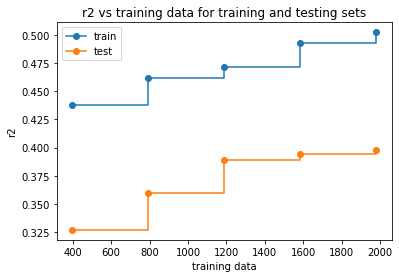

In [128]:
n_splits = 5
n = X_train.shape[0] // n_splits
ind = [i*n for i in range(5)]
ind.reverse()
r2 = {}
for i in range(n_splits):
    ix = [j >= ind[i] for j in range(X_train.shape[0])]
    X_train_i = X_train[ix]
    y_train_i = y_train[ix]
    clf = KNeighborsRegressor(n_neighbors=9)
    clf.fit(X_train_i, y_train_i)
    pred_y_test = clf.predict(X_test)
    pred_y_i = clf.predict(X_train_i)
    r2[ind[i]+n] = r2_score(y_train_i, pred_y_i), r2_score(y_test, pred_y_test) 
plt = plot_learning('r2',x='training data')
plt.savefig('./paper/figures/house_knn_learn_r2_data.png', format='png', transparent=True)
plt.show()

#### Use k-fold validation

In [112]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
kf.get_n_splits(X)

KNNs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn, knn_score = return_best_model(X_train, X_test, y_train, y_test)
    #print(knn.score(X_test, y_test))
    KNNs.append(knn)
    
preds = np.empty((y_val.shape[0], n_splits))
for i in range(n_splits):
    print(KNNs[i])
    preds[:,i] = KNNs[i].predict(X_val)
    

y_val_hat = np.mean(preds, axis=1)

r2_score(y_val, y_val_hat)





KNeighborsRegressor(weights='distance')
KNeighborsRegressor()
KNeighborsRegressor()
KNeighborsRegressor()
KNeighborsRegressor()


0.4013633447930183

#### Maybe some feature selection on X?

In [114]:


KNNs = np.empty((n_splits, X.shape[1]))
KNN_full = np.empty((n_splits,1))
dims = list(range(X.shape[1]))
ix = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn, knn_score = return_best_model(X_train, X_test, y_train, y_test)
    KNN_full[ix,0] = knn.score(X_test, y_test)
    for i in dims:
        index = [i]
        knn, knn_score = return_best_model(X_train[:,index], X_test[:,index], y_train, y_test)
        #print(knn.score(X_test, y_test))
        KNNs[ix,i] = knn.score(X_test[:,index], y_test)
    
    ix += 1
    

#### Find the dimensions that performed better on their own

In [115]:
colnames = ['day', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
           'floors', 'waterfront', 'view', 'condition', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'lat','lon']
chg = []

for i in range(X.shape[1]):
    chg.append(np.mean(KNN_full) - np.mean(KNNs[:,i], axis = 0))
    print(colnames[i], np.mean(KNNs[:,i], axis = 0) - np.mean(KNN_full))

day -0.5381921149894853
bedrooms -0.41296939528576687
bathrooms -0.22607015256475135
sqft_living -0.06597971971922839
sqft_lot -0.4870567267806677
floors -0.5898628390815653
waterfront -0.3886683734712812
view -0.33449663237440747
condition -0.5409657947456945
sqft_above -0.20736584453443357
sqft_basement -0.4161756984186408
yr_built -0.5107504519681736
yr_renovated -0.5537639324089848
lat -0.18516890855121726
lon -0.4759566946352702


#### Start with best and add features, check test data

In [131]:
import scipy.stats as ss
KNNs = []
feats = list(range(X.shape[1]))

# rank the features
ranks = ss.rankdata(chg)

tracker = {}

for ii in range(len(feats)):
    good_feats = [feats[i] for i in range(len(chg)) if ranks[i]-1 <= ii]
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn, knn_score = return_best_model(X_train[:,good_feats], X_test[:,good_feats], y_train, y_test)
        scores.append(knn_score)
        KNNs.append(knn)
    tracker[(tuple(good_feats), knn)] =  np.mean(scores)
    
tracker
    
    
    


{((3,), KNeighborsRegressor(n_neighbors=9)): 0.360882357430738,
 ((3, 13),
  KNeighborsRegressor(n_neighbors=7, weights='distance')): 0.46392625330093706,
 ((3, 9, 13), KNeighborsRegressor(n_neighbors=9)): 0.42587253044390644,
 ((2, 3, 9, 13), KNeighborsRegressor(n_neighbors=9)): 0.40717648145945595,
 ((2, 3, 7, 9, 13), KNeighborsRegressor(n_neighbors=9)): 0.4066178061227923,
 ((2, 3, 6, 7, 9, 13), KNeighborsRegressor(n_neighbors=9)): 0.4066178061227923,
 ((1, 2, 3, 6, 7, 9, 13),
  KNeighborsRegressor(n_neighbors=9)): 0.3963592299229516,
 ((1, 2, 3, 6, 7, 9, 10, 13),
  KNeighborsRegressor(n_neighbors=9)): 0.3954720593236615,
 ((1, 2, 3, 6, 7, 9, 10, 13, 14),
  KNeighborsRegressor(n_neighbors=9)): 0.394085323158632,
 ((1, 2, 3, 4, 6, 7, 9, 10, 13, 14),
  KNeighborsRegressor(n_neighbors=9)): 0.41053979524372364,
 ((1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 14),
  KNeighborsRegressor(n_neighbors=9)): 0.4129453332217917,
 ((0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 14),
  KNeighborsRegressor(n_neighbors=

#### Only use combination of features that worked the best to score the validation data

In [132]:
best_score = -np.infty
for key, value in tracker.items():
    if value > best_score:
        feats, knn = key
        best_score = value
        
print("Best features/model:", feats, knn)


y_val_hat = knn.predict(X_val[:,list(feats)])

print("KNN performance on validation data:", r2_score(y_val, y_val_hat))

Best features/model: (3, 13) KNeighborsRegressor(n_neighbors=7, weights='distance')
KNN performance on validation data: 0.4720271717747051


## Artificial Neural Networks

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

import time

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

#### Start with simple ANN

In [6]:
# scale the data
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [7]:
def train_loop(ann, epochs):
    training_scores = []
    testing_scores = []
    best = -1000
    best_ann = None
    for epoch in range(epochs):
        ann.fit(X_train, y_train)
        test_score = ann.score(X_test, y_test)
        training_scores.append(ann.score(X_train, y_train))
        testing_scores.append(test_score)
        if test_score > best:
            best = test_score
            best_ann = ann
            
    print("Final train/test scores:", training_scores[-1], testing_scores[-1])
    
    return ann, training_scores, testing_scores, best_ann

def plot_learning():
    epoch_list = list(range(epochs))
    fig, ax = plt.subplots()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("R2 Score")
    ax.set_title("Learning Curves for ANN")
    ax.plot(epoch_list, training_scores, label="train")
    ax.plot(epoch_list, testing_scores, label="test")
    plt.ylim((0,1))
    ax.legend()
    return plt

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Final train/test scores: 0.5671391466121285 0.6273703721624553


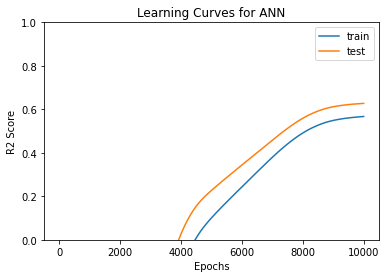

In [144]:
# initiate and train loop
epochs = 10000
params = {
    'hidden_layer_sizes':(100,),
    'activation':'relu',
    'learning_rate_init':0.001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPRegressor(**params)

ann, training_scores, testing_scores, best_ann = train_loop(ann, epochs)


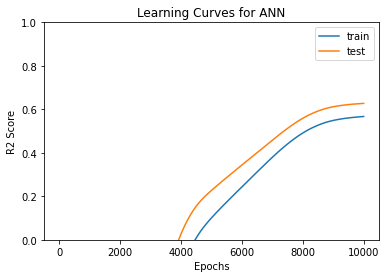

In [160]:
plt = plot_learning()
plt.savefig('./paper/figures/house_ann_100.png', format='png', transparent=True)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Final train/test scores: 0.8274907496309374 0.6907931566092325


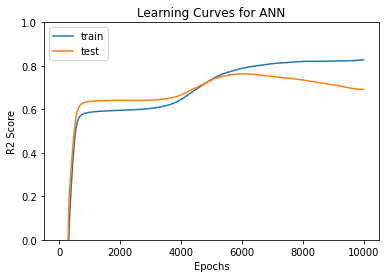

In [10]:
# initiate and train loop
epochs = 10000
params = {
    'hidden_layer_sizes':(100,100),
    'activation':'relu',
    'learning_rate_init':0.001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPRegressor(**params)

ann, training_scores, testing_scores, best_ann = train_loop(ann, epochs)
plt = plot_learning()
plt.savefig('./paper/figures/house_ann_100x2.png', format='png', transparent=True)

In [14]:
r2_score(y_test, best_ann.predict(X_test)), r2_score(y_val, best_ann.predict(X_val_scaled))

(0.6907931566092325, 0.6232685459409506)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Final train/test scores: 0.7876773366796082 0.6989704893750778


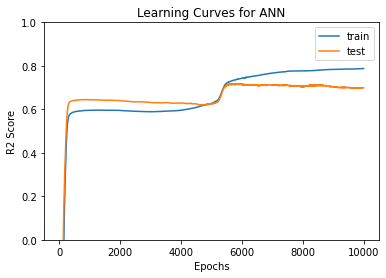

In [15]:
# initiate and train loop
epochs = 10000
params = {
    'hidden_layer_sizes':(10,10,10,10,10,10),
    'activation':'relu',
    'learning_rate_init':0.001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPRegressor(**params)
ann, training_scores, testing_scores, best_ann = train_loop(ann, epochs)
plt = plot_learning()
plt.savefig('./paper/figures/house_ann_10x6.png', format='png', transparent=True)

In [16]:
r2_score(y_test, best_ann.predict(X_test)), r2_score(y_val, best_ann.predict(X_val_scaled))

(0.6989704893750778, 0.6797794851268806)

In [ ]:
# initiate and train loop
epochs = 10000
params = {
    'hidden_layer_sizes':(1000,1000),
    'activation':'relu',
    'learning_rate_init':0.001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPRegressor(**params)
ann, training_scores, testing_scores, best_ann = train_loop(ann, epochs)
plt = plot_learning()
plt.savefig('./paper/figures/house_ann_1000x2.png', format='png', transparent=True)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [788]:
lats = np.arange(np.min(X[:,13]), np.max(X[:,13]), np.abs(np.min(X[:,13]) - np.max(X[:,13]))/1000)
lons = np.arange(np.min(X[:,14]), np.max(X[:,14]), np.abs(np.min(X[:,14]) - np.max(X[:,14]))/1000)

x1, x2 = np.meshgrid(lats, lons)

p = np.empty(x1.shape)

for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        var = np.empty((15,))
        var[0:13] = means
        var[13] = x1[i,j]
        var[14] = x2[i,j]
        var = var.reshape(1, -1)
        scaler.transform(var)
        p[i,j] = ann.predict(var)

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(x1, x2, p)

KeyboardInterrupt: 

In [28]:
# initiate and train loop
epochs = 1000
params = {
    'hidden_layer_sizes':(1000,1000,1000),
    'activation':'relu',
    'learning_rate_init':0.001,
    'random_state':0,
    'max_iter':1,
    'warm_start':True,
    'alpha':0.0001,
         }

ann = MLPRegressor(**params)

training_scores = []
testing_scores = []
for epoch in range(epochs):
    ann.fit(X_train[:,13:15], y_train)
    training_scores.append(ann.score(X_train[:,13:15], y_train))
    testing_scores.append(ann.score(X_test[:,13:15], y_test))

print("Final train/test scores:", training_scores[-1], testing_scores[-1])

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Final train/test scores: -0.003300063588347779 -0.010105458785838461


/var/folders/fb/q0847hz132l4ztpn_6wjzxtw0000gn/T/ipykernel_78415/319342770.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(x1, x2, p)


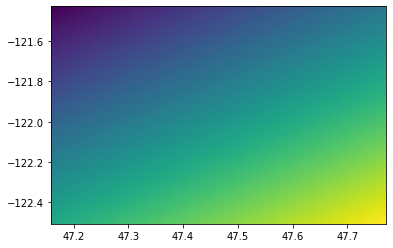

In [803]:
lats = np.arange(np.min(X[:,13]), np.max(X[:,13]), np.abs(np.min(X[:,13]) - np.max(X[:,13]))/100)
lons = np.arange(np.min(X[:,14]), np.max(X[:,14]), np.abs(np.min(X[:,14]) - np.max(X[:,14]))/100)

x1, x2 = np.meshgrid(lats, lons)

p = np.empty(x1.shape)

for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        var = np.empty((15,))
        var[0:13] = means
        var[13] = x1[i,j]
        var[14] = x2[i,j]
        var = var.reshape(1, -1)
        scaler.transform(var)
        p[i,j] = ann.predict(var[:,13:15])

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(x1, x2, p)

ValueError: not enough values to unpack (expected 2, got 1)

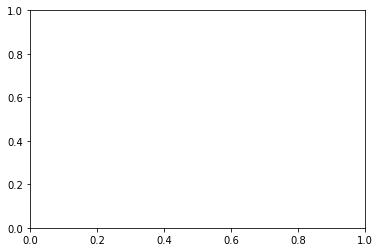

In [28]:
lats = np.arange(np.min(X[:,13]), np.max(X[:,13]), np.abs(np.min(X[:,13]) - np.max(X[:,13]))/100)
lons = np.arange(np.min(X[:,14]), np.max(X[:,14]), np.abs(np.min(X[:,14]) - np.max(X[:,14]))/100)

x1, x2 = np.meshgrid(lats, lons)

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(x1, x2, y)

In [27]:
(X[:,13]>47.1593242) & (X[:,13]<47.16550295)

1

In [38]:
lats = np.arange(np.min(X[:,13]), np.max(X[:,13]), np.abs(np.min(X[:,13]) - np.max(X[:,13]))/25)
lons = np.arange(np.min(X[:,14]), np.max(X[:,14]), np.abs(np.min(X[:,14]) - np.max(X[:,14]))/25)

x1, x2 = np.meshgrid(lats, lons)

p = np.empty(x1.shape)
for i in range(x1.shape[0]-1):
    for j in range(x1.shape[1]-1):
        p[i,j] = np.mean(y[(X[:,13]>x1[i,j]) & (X[:,14]<x1[i,j+1]) & (X[:,14]>x2[i,j]) & (X[:,14]<x2[i+1,j])])
        

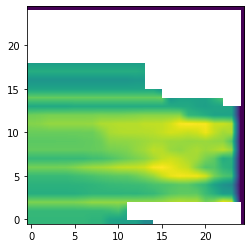

In [40]:
plt.imshow(p,origin='lower',interpolation='bilinear')

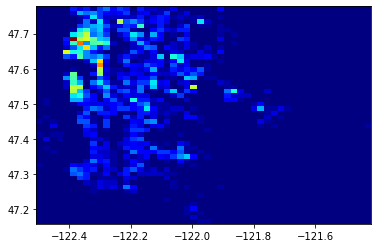

In [32]:
plt.hist2d(X[:,14], X[:,13], bins=(50, 50), cmap=plt.cm.jet)
plt.show()

## Boosting

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

In [27]:
params = {
    "n_estimators": 1000,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params).fit(X_train, y_train)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_split=5,
                          n_estimators=1000)

In [28]:
train_score = np.zeros((params["n_estimators"],), dtype=np.float64)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = r2_score(y_test, y_pred)
for i, y_pred in enumerate(reg.staged_predict(X_train)):
    train_score[i] = r2_score(y_train, y_pred)

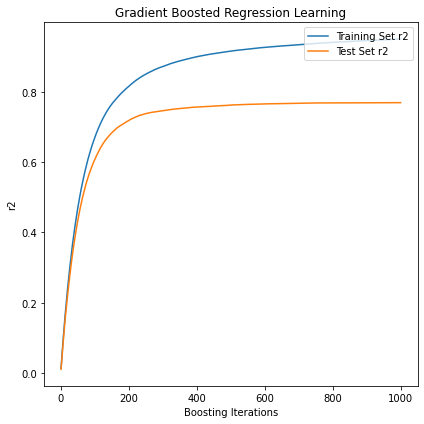

In [29]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Gradient Boosted Regression Learning")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    train_score,
    label="Training Set r2",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, label="Test Set r2"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("r2")
fig.tight_layout()
plt.savefig('./paper/figures/boost_r2.png', format='png', transparent=True)
plt.show()

In [23]:
r2_score(y_test, reg.predict(X_test)), r2_score(y_val, reg.predict(X_val))

(0.7695973764316298, 0.7765821843608173)

### Support Vector Machines

In [44]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2072020)

In [46]:
def plot_learning(val = 'roc_auc', x = 'max depth'):
    D = eval(val)
    depths = sorted(D.keys())
    train_scores = [value[0] for key, value in D.items()]
    test_scores = [value[1] for key, value in D.items()]
    
    
    fig, ax = plt.subplots()
    ax.set_xlabel(x)
    ax.set_ylabel(val)
    ax.set_title(val + " vs " + x + " for training and testing sets")
    ax.plot(depths, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(depths, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax.legend()
    return plt

In [47]:
# scale the data
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X)

In [48]:
params = {'kernel':'poly','degree':5, 'C':10,'gamma':'auto'}

clf = svm.SVR(**params)

clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Training roc_auc, test roc_auc:")
print(r2_score(y_train, pred_y), r2_score(y_test, pred_y_test))

Training roc_auc, test roc_auc:
-0.00494462275775942 -0.033492126944684175


In [49]:
params = {'kernel':'rbf', 'C':100,'gamma':'auto'}

clf = svm.SVR(**params)

clf.fit(X_train, y_train)
pred_y = clf.predict(X_train)
pred_y_test = clf.predict(X_test)
print("Training roc_auc, test roc_auc:")
print(r2_score(y_train, pred_y), r2_score(y_test, pred_y_test))

Training roc_auc, test roc_auc:
-0.013161554488895444 -0.03026871273395315


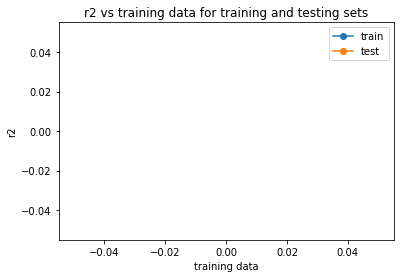

In [50]:
params = {'kernel':'poly','degree':5, 'C':1,'gamma':'auto'}

n_splits = 5
n = X_train.shape[0] // n_splits
ind = [i*n for i in range(5)]
ind.reverse()
r2 = {}
for i in range(n_splits):
    ix = [j >= ind[i] for j in range(X_train.shape[0])]
    X_train_i = X_train[ix]
    y_train_i = y_train[ix]
    clf = svm.SVR(**params)
    clf.fit(X_train_i, y_train_i)
    pred_y_test = clf.predict(X_test)
    pred_y_i = clf.predict(X_train_i)
    auc[ind[i]+n] = r2_score(y_train_i, pred_y_i), r2_score(y_test, pred_y_test) 
plt = plot_learning('r2', x="training data")
plt.savefig('./paper/figures/house_svm_learn_r2_data.png', format='png', transparent=True)
plt.show()

In [12]:
scaler = StandardScaler() 
scaler.fit(X)
X_scaled = scaler.transform(X)

parameters = {'kernel':('linear', 'rbf','poly'), 'C':[1, 10, 100],'gamma':('auto','scale'),
             'epsilon':[0.001,.01,.1,.5]}

reg = svm.SVR()
clf = GridSearchCV(reg, parameters)
clf.fit(X_scaled, y)
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_epsilon',
 'param_gamma',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [17]:
clf.cv_results_

{'mean_fit_time': array([0.18502107, 0.25257459, 0.19444146, 0.17775245, 0.25251274,
        0.19331222, 0.17833176, 0.26266022, 0.1937191 , 0.18710718,
        0.25400577, 0.20184746, 0.17828345, 0.25160379, 0.19622121,
        0.17779784, 0.25221386, 0.1944828 , 0.17883067, 0.25269561,
        0.19437022, 0.17980499, 0.25381756, 0.19380398, 0.17720723,
        0.25232153, 0.19416037, 0.1762527 , 0.25306969, 0.19448032,
        0.17666373, 0.25101705, 0.19492083, 0.17517142, 0.25222926,
        0.19525485, 0.17651024, 0.25301552, 0.19514055, 0.18131022,
        0.25709424, 0.1954566 , 0.17603683, 0.25416985, 0.19447913,
        0.17541394, 0.25647297, 0.19854765, 0.17684312, 0.25673037,
        0.20348306, 0.17632356, 0.25637636, 0.20649557, 0.17515903,
        0.25184398, 0.19715724, 0.17405486, 0.25430841, 0.19689741,
        0.17509093, 0.25291872, 0.19734101, 0.17418828, 0.25397153,
        0.2005559 , 0.17415109, 0.25213118, 0.1977428 , 0.17213244,
        0.25245023, 0.19697118]